# Neural Network implementation with Pytorch

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

torch.manual_seed(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch version: {torch.__version__}')
print(f'Using device: {device}')

PyTorch version: 2.7.1
Using device: cpu


In [3]:
if torch.cuda.is_available():
    print(f'CUDA devices: {torch.cuda.device_count()}')
    for idx in range(torch.cuda.device_count()):
        print(f'  {idx}: {torch.cuda.get_device_name(idx)}')
else:
    print('CUDA not available, training on CPU.')


CUDA not available, training on CPU.


In [4]:
X_train = pd.read_csv('../data/splits/X_train.csv').values.astype(np.float32)
y_train = pd.read_csv('../data/splits/y_train.csv').values.astype(np.int64).ravel()
original_Xtest = pd.read_csv('../data/splits/Xtest.csv').values.astype(np.float32)
original_ytest = pd.read_csv('../data/splits/ytest.csv').values.astype(np.int64).ravel()
Xsm_train = pd.read_csv('../data/splits/Xsm_train.csv').values.astype(np.float32)
ysm_train = pd.read_csv('../data/splits/ysm_train.csv').values.astype(np.int64).ravel()


# PyTorch + UnderSampling

In [5]:
class FraudNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.layers(x)


def train_model(model, features, labels, *, lr, batch_size, epochs, val_split, model_name = None):
    dataset = TensorDataset(torch.from_numpy(features), torch.from_numpy(labels))

    if val_split > 0 and len(dataset) > 1:
        proposed_val = int(len(dataset) * val_split)
        val_size = max(1, min(len(dataset) - 1, proposed_val))
        train_size = len(dataset) - val_size
        generator = torch.Generator().manual_seed(42)
        train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=generator)
        val_loader = DataLoader(val_ds, batch_size=batch_size)
    else:
        train_ds = dataset
        val_loader = None

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = []
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = train_correct = train_count = 0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * xb.size(0)
            train_correct += (outputs.argmax(dim=1) == yb).sum().item()
            train_count += xb.size(0)

        epoch_stats = {
            'epoch': epoch,
            'loss': train_loss / train_count,
            'accuracy': train_correct / train_count
        }

        if val_loader is not None:
            model.eval()
            val_loss = val_correct = val_count = 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(device)
                    yb = yb.to(device)
                    outputs = model(xb)
                    loss = criterion(outputs, yb)
                    val_loss += loss.item() * xb.size(0)
                    val_correct += (outputs.argmax(dim=1) == yb).sum().item()
                    val_count += xb.size(0)

            epoch_stats['val_loss'] = val_loss / val_count
            epoch_stats['val_accuracy'] = val_correct / val_count
            print(f"Epoch {epoch}/{epochs} - loss: {epoch_stats['loss']:.4f} - acc: {epoch_stats['accuracy']:.4f} - val_loss: {epoch_stats['val_loss']:.4f} - val_acc: {epoch_stats['val_accuracy']:.4f}")
        else:
            print(f"Epoch {epoch}/{epochs} - loss: {epoch_stats['loss']:.4f} - acc: {epoch_stats['accuracy']:.4f}")

        history.append(epoch_stats)

    torch.save(model.state_dict(), f'../models/{model_name}_weights.pth')

    return model.to(device), history


def predict_probabilities(model, features):
    model.eval()
    with torch.no_grad():
        inputs = torch.from_numpy(features).to(device)
        logits = model(inputs)
        return torch.softmax(logits, dim=1).cpu().numpy()


In [6]:
undersample_model = FraudNet(X_train.shape[1]).to(device)
print(undersample_model)


FraudNet(
  (layers): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [7]:
print(X_train.dtype, y_train.dtype)
print(np.isnan(X_train).sum(), np.isnan(y_train).sum())
print(np.isinf(X_train).sum(), np.isinf(y_train).sum())
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)
print(X_train.shape, y_train.shape)


float32 int64
0 0
0 0
<class 'numpy.ndarray'> (756, 30)
<class 'numpy.ndarray'> (756,)
(756, 30) (756,)


In [8]:
lr = 0.001
valid_split = 0.2
batch_size = 32
epochs = 10

undersample_model, undersample_history = train_model(
    undersample_model,
    X_train,
    y_train,
    lr = lr,
    batch_size = batch_size,
    epochs = epochs,
    val_split = valid_split, 
    model_name = "undersample_model"
)


Epoch 1/10 - loss: 0.6048 - acc: 0.4595 - val_loss: 0.4971 - val_acc: 0.6291
Epoch 2/10 - loss: 0.4678 - acc: 0.7174 - val_loss: 0.4042 - val_acc: 0.8543
Epoch 3/10 - loss: 0.3868 - acc: 0.9140 - val_loss: 0.3266 - val_acc: 0.9205
Epoch 4/10 - loss: 0.3113 - acc: 0.9372 - val_loss: 0.2602 - val_acc: 0.9205
Epoch 5/10 - loss: 0.2446 - acc: 0.9405 - val_loss: 0.2132 - val_acc: 0.9205
Epoch 6/10 - loss: 0.1926 - acc: 0.9421 - val_loss: 0.2039 - val_acc: 0.9073
Epoch 7/10 - loss: 0.1614 - acc: 0.9455 - val_loss: 0.2129 - val_acc: 0.9073
Epoch 8/10 - loss: 0.1423 - acc: 0.9504 - val_loss: 0.2245 - val_acc: 0.9139
Epoch 9/10 - loss: 0.1304 - acc: 0.9488 - val_loss: 0.2413 - val_acc: 0.9139
Epoch 10/10 - loss: 0.1226 - acc: 0.9504 - val_loss: 0.2380 - val_acc: 0.9139


In [9]:
undersample_predictions = predict_probabilities(undersample_model, original_Xtest)
undersample_fraud_predictions = (undersample_predictions[:, 1] > 0.5).astype('int32')


In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[55506  1357]
 [    9    89]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


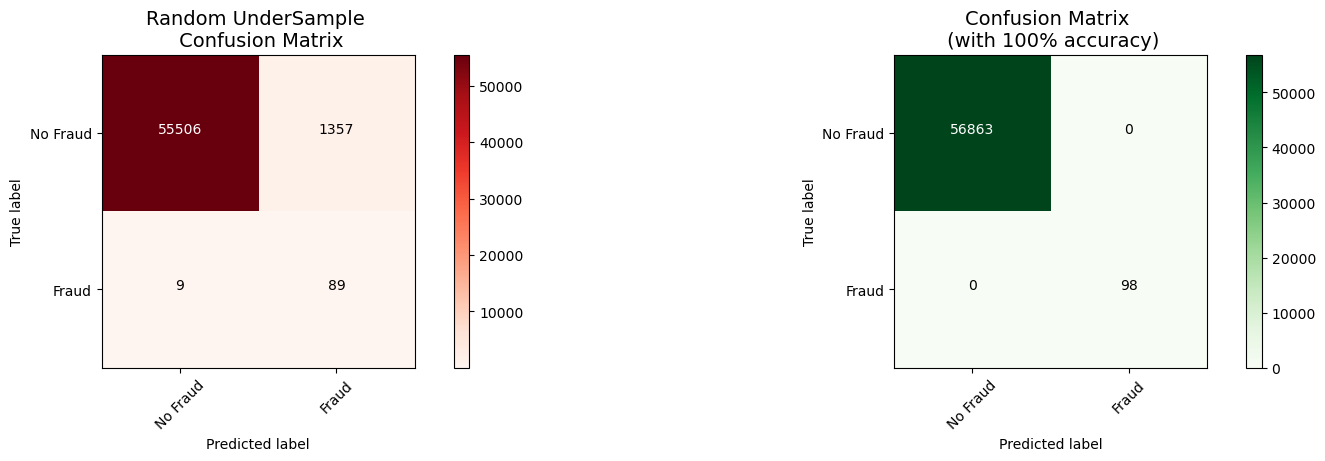

In [11]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

# PyTorch + OverSampling

In [12]:
oversample_model = FraudNet(Xsm_train.shape[1]).to(device)
print(oversample_model)


FraudNet(
  (layers): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [13]:
lr = 0.001
valid_split = 0.2
batch_size = 300
epochs = 20

oversample_model, oversample_history = train_model(
    oversample_model,
    Xsm_train,
    ysm_train,
    lr = lr,
    batch_size = batch_size,
    epochs = epochs,
    val_split = valid_split,
    model_name = "oversample_model"
)


Epoch 1/20 - loss: 0.0622 - acc: 0.9792 - val_loss: 0.0142 - val_acc: 0.9965
Epoch 2/20 - loss: 0.0104 - acc: 0.9978 - val_loss: 0.0075 - val_acc: 0.9983
Epoch 3/20 - loss: 0.0065 - acc: 0.9986 - val_loss: 0.0052 - val_acc: 0.9987
Epoch 4/20 - loss: 0.0047 - acc: 0.9991 - val_loss: 0.0049 - val_acc: 0.9989
Epoch 5/20 - loss: 0.0038 - acc: 0.9992 - val_loss: 0.0039 - val_acc: 0.9991
Epoch 6/20 - loss: 0.0032 - acc: 0.9994 - val_loss: 0.0028 - val_acc: 0.9994
Epoch 7/20 - loss: 0.0028 - acc: 0.9994 - val_loss: 0.0026 - val_acc: 0.9996
Epoch 8/20 - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0028 - val_acc: 0.9994
Epoch 9/20 - loss: 0.0023 - acc: 0.9995 - val_loss: 0.0022 - val_acc: 0.9996
Epoch 10/20 - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0025 - val_acc: 0.9994
Epoch 11/20 - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0019 - val_acc: 0.9996
Epoch 12/20 - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0022 - val_acc: 0.9997
Epoch 13/20 - loss: 0.0016 - acc: 0.9997 - val_loss: 0.0023 - val_acc: 0.

In [14]:
oversample_predictions = predict_probabilities(oversample_model, original_Xtest)
oversample_fraud_predictions = (oversample_predictions[:, 1] > 0.5).astype('int32')


Confusion matrix, without normalization
[[56843    20]
 [   29    69]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


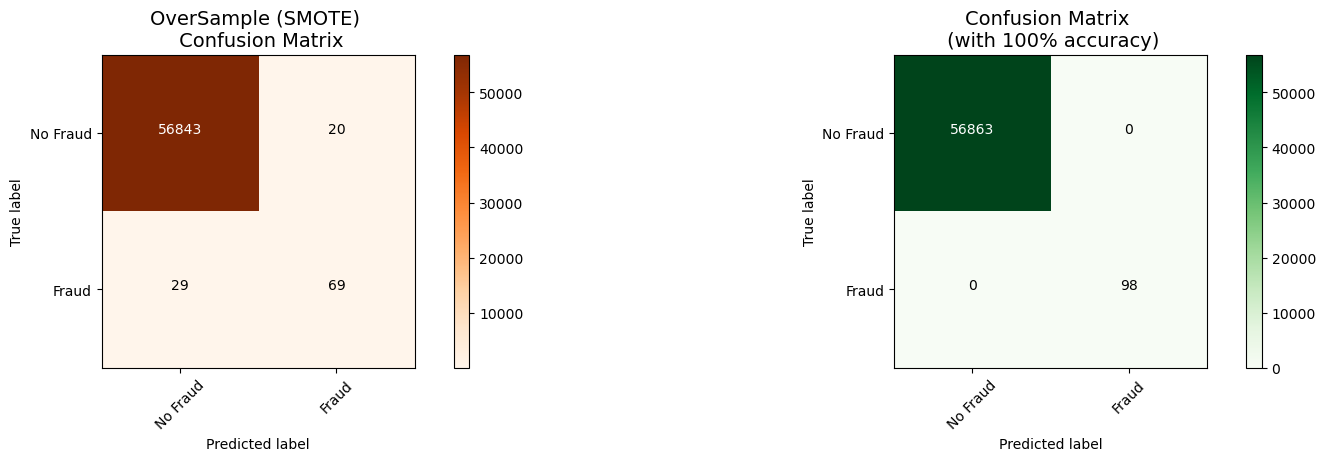

In [15]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)